In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa
from tqdm.notebook import tqdm


In [ ]:
AGE_MAP = {
    'teens': 0,
    'twenties': 1,
    'thirties': 2,
    'fourties': 3,
    'fifties': 4,
    '60plus': 5
}
NUM_AGE_CLASSES = 6

In [ ]:
GENDER_MAP = {
    'female': 0,
    'male': 1
}
NUM_GENDER_CLASSES = 2

In [ ]:


class VoiceDataset(Dataset):
    """
    Custom PyTorch Dataset for loading voice spectrograms.
    It loads a .npy file, applies scaling, and returns the
    spectrogram and its corresponding age & gender labels.
    """
    def __init__(self, csv_file, features_dir, mean, std):
        """
        This is the constructor, run once when we create the dataset.

        Args:
            csv_file (string): Path to the csv file (train, val, or test).
            features_dir (string): Directory with all the .npy spectrograms.
            mean (float): The global mean we calculated.
            std (float): The global std we calculated.
        """
        self.data_list = pd.read_csv(csv_file)
        self.features_dir = features_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        """
        This function just returns the total number of samples in the dataset.
        PyTorch uses this to know how many items are in the list.
        """
        return len(self.data_list)

    def __getitem__(self, idx):
        """
        This is the most important function. It loads and returns ONE
        sample (spectrogram + labels) from the dataset at the given index 'idx'.
        """

        # 1. Get metadata from the CSV
        row = self.data_list.iloc[idx]

        # 2. Build the file path
        filename = row['path'].replace(".mp3", ".npy")
        file_path = os.path.join(self.features_dir, filename)

        # 3. Load the spectrogram array
        spectrogram = np.load(file_path)

        # 4. APPLY SCALING
        # (data - mean) / std
        spectrogram = (spectrogram - self.mean) / self.std

        # 5. Add a "channel" dimension
        # A CNN model expects an input shape of [Channels, Height, Width]
        # (Just like an RGB image is [3, 224, 224])
        # Our spectrogram is grayscale, so it has 1 channel.
        # This changes the shape from (128, 216) -> (1, 128, 216)
        spectrogram = np.expand_dims(spectrogram, axis=0)

        # 6. Look up and encode the labels
        age_label = AGE_MAP[row['age']]
        gender_label = GENDER_MAP[row['gender']]

        # 7. Convert everything to PyTorch Tensors
        # The model only understands tensors.
        spec_tensor = torch.tensor(spectrogram, dtype=torch.float32)
        age_tensor = torch.tensor(age_label, dtype=torch.long) # Use .long for labels
        gender_tensor = torch.tensor(gender_label, dtype=torch.long) # Use .long for labels

        # Return the three tensors
        return spec_tensor, age_tensor, gender_tensor

In [ ]:

stats_path = "/content/drive/MyDrive/voice_project/scaling_stats"
features_path = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
val_list_path = "/content/drive/MyDrive/voice_project/val_list.csv"


GLOBAL_MEAN = np.load(os.path.join(stats_path, "global_mean.npy"))
GLOBAL_STD = np.load(os.path.join(stats_path, "global_std.npy"))

print(f"Loaded stats: Mean={GLOBAL_MEAN:.2f}, Std={GLOBAL_STD:.2f}")

# Instantiate and Test the Dataset
print("Creating validation dataset...")
val_dataset = VoiceDataset(
    csv_file=val_list_path,
    features_dir=features_path,
    mean=GLOBAL_MEAN,
    std=GLOBAL_STD
)

print(f"Dataset created with {len(val_dataset)} samples.")

# Pull the first sample (index 0)
spec, age, gender = val_dataset[0]

print("\n--- Testing sample 0 ---")
print(f"Spectrogram shape: {spec.shape} (Should be [1, 128, 216])")
print(f"Age label: {age} (Tensor)")
print(f"Gender label: {gender} (Tensor)")

# Check the scaling
print(f"Scaled spectrogram mean: {spec.mean():.2f} (Should be near 0)")
print(f"Scaled spectrogram std: {spec.std():.2f} (Should be near 1)")

Loaded stats: Mean=-59.25, Std=11.95
Creating validation dataset...
Dataset created with 1535 samples.

--- Testing sample 0 ---
Spectrogram shape: torch.Size([1, 128, 216]) (Should be [1, 128, 216])
Age label: 5 (Tensor)
Gender label: 1 (Tensor)
Scaled spectrogram mean: 0.08 (Should be near 0)
Scaled spectrogram std: 1.61 (Should be near 1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VoiceCNN(nn.Module):
    def __init__(self, num_age_classes, num_gender_classes):
        super(VoiceCNN, self).__init__()

        # 1. The "Body" (Convolutional Layers)


        # Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        # We flatten the output of the last pool layer to feed it to the heads
        # 64 (channels) * 16 (height) * 27 (width) = 27648
        self.flatten = nn.Flatten()

        # This is the shared, "learned features" layer
        self.fc_shared = nn.Linear(64 * 16 * 27, 128)
        self.fc_bn = nn.BatchNorm1d(128)
        self.fc_relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Dropout for regularization

        # 3. The "Heads" (Multi-Task Outputs)

        # Head 1: Age Prediction
        self.age_head = nn.Linear(128, num_age_classes)

        # Head 2: Gender Prediction
        self.gender_head = nn.Linear(128, num_gender_classes)

    def forward(self, x):
        # Pass through the Body
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))

        # Pass through the Neck
        x = self.flatten(x)
        x = self.dropout(self.fc_relu(self.fc_bn(self.fc_shared(x))))

        # Pass through the Heads
        age_output = self.age_head(x)
        gender_output = self.gender_head(x)

        return age_output, gender_output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
model = VoiceCNN(num_age_classes=NUM_AGE_CLASSES, num_gender_classes=NUM_GENDER_CLASSES)
model.to(device)

VoiceCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_shared): Linear(in_features=27648, out_features=128, bias=True)
  (fc_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
dummy_input = torch.randn(4, 1, 128, 216).to(device)

In [ ]:
age_preds, gender_preds = model(dummy_input)

In [ ]:
print(f"Input shape: {dummy_input.shape}")
print(f"Age output shape: {age_preds.shape} (Should be [4, {NUM_AGE_CLASSES}])")
print(f"Gender output shape: {gender_preds.shape} (Should be [4, {NUM_GENDER_CLASSES}])")

# You can also print the model summary
from torchsummary import summary
try:
    !pip install -q torchsummary
    from torchsummary import summary
    summary(model, (1, 128, 216))
except ImportError:
    print("\n(Could not import torchsummary, skipping summary.)")
    print(model)

Input shape: torch.Size([4, 1, 128, 216])
Age output shape: torch.Size([4, 6]) (Should be [4, 6])
Gender output shape: torch.Size([4, 2]) (Should be [4, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 216]             160
       BatchNorm2d-2         [-1, 16, 128, 216]              32
              ReLU-3         [-1, 16, 128, 216]               0
         MaxPool2d-4          [-1, 16, 64, 108]               0
            Conv2d-5          [-1, 32, 64, 108]           4,640
       BatchNorm2d-6          [-1, 32, 64, 108]              64
              ReLU-7          [-1, 32, 64, 108]               0
         MaxPool2d-8           [-1, 32, 32, 54]               0
            Conv2d-9           [-1, 64, 32, 54]          18,496
      BatchNorm2d-10           [-1, 64, 32, 54]             128
             ReLU-11           [-1, 64, 32, 54]               0
        Ma

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import os
import time
import numpy as np

# 1. Define Constants
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
MODEL_SAVE_PATH = "/content/drive/MyDrive/voice_project/best_voice_model.pth"

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load Stats and Define Paths
stats_path = "/content/drive/MyDrive/voice_project/scaling_stats"
features_path = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
train_list_path = "/content/drive/MyDrive/voice_project/train_list.csv"
val_list_path = "/content/drive/MyDrive/voice_project/val_list.csv"

GLOBAL_MEAN = np.load(os.path.join(stats_path, "global_mean.npy"))
GLOBAL_STD = np.load(os.path.join(stats_path, "global_std.npy"))

# 3. Create DataLoaders
print("Creating Datasets and DataLoaders...")

# Create the datasets
train_dataset = VoiceDataset(
    csv_file=train_list_path,
    features_dir=features_path,
    mean=GLOBAL_MEAN,
    std=GLOBAL_STD
)

val_dataset = VoiceDataset(
    csv_file=val_list_path,
    features_dir=features_path,
    mean=GLOBAL_MEAN,
    std=GLOBAL_STD
)

# Create the loaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle training data
    num_workers=2  # Use 2 CPU cores to pre-load data
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=2
)

print(f"Train loader: {len(train_loader)} batches")
print(f"Validation loader: {len(val_loader)} batches")

# 4. Initialize Model, Loss, and Optimizer ---
model = VoiceCNN(num_age_classes=NUM_AGE_CLASSES, num_gender_classes=NUM_GENDER_CLASSES)
model.to(device)

# Loss functions
criterion_age = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5. The Training Loop
print("\n--- Starting Training ---")
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    # Training Phase
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_age = 0
    correct_gender = 0
    total_samples = 0

    for specs, ages, genders in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        # Move data to GPU
        specs = specs.to(device)
        ages = ages.to(device)
        genders = genders.to(device)

        # 1. Forward pass
        age_preds, gender_preds = model(specs)

        # 2. Calculate loss
        loss_age = criterion_age(age_preds, ages)
        loss_gender = criterion_gender(gender_preds, genders)
        loss = loss_age + loss_gender # Total loss

        # 3. Backward pass and optimize
        optimizer.zero_grad() # Clear old gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update model weights

        # Track statistics
        running_loss += loss.item() * specs.size(0)

        # Get accuracy
        _, predicted_age = torch.max(age_preds, 1)
        _, predicted_gender = torch.max(gender_preds, 1)

        total_samples += genders.size(0)
        correct_age += (predicted_age == ages).sum().item()
        correct_gender += (predicted_gender == genders).sum().item()

    # Calculate average training stats
    train_loss = running_loss / total_samples
    train_acc_age = 100 * correct_age / total_samples
    train_acc_gender = 100 * correct_gender / total_samples

    # Validation Phase
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_age = 0
    correct_gender = 0
    total_samples = 0

    with torch.no_grad():
        for specs, ages, genders in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            specs = specs.to(device)
            ages = ages.to(device)
            genders = genders.to(device)

            age_preds, gender_preds = model(specs)

            loss_age = criterion_age(age_preds, ages)
            loss_gender = criterion_gender(gender_preds, genders)
            loss = loss_age + loss_gender

            val_loss += loss.item() * specs.size(0)

            _, predicted_age = torch.max(age_preds, 1)
            _, predicted_gender = torch.max(gender_preds, 1)

            total_samples += genders.size(0)
            correct_age += (predicted_age == ages).sum().item()
            correct_gender += (predicted_gender == genders).sum().item()

    # Calculate average validation stats
    val_loss = val_loss / total_samples
    val_acc_age = 100 * correct_age / total_samples
    val_acc_gender = 100 * correct_gender / total_samples

    end_time = time.time()

    # Epoch Summary
    print(f"\nEpoch {epoch+1}/{EPOCHS} | Time: {end_time - start_time:.2f}s")
    print(f"  [Train] Loss: {train_loss:.4f} | Age Acc: {train_acc_age:.2f}% | Gender Acc: {train_acc_gender:.2f}%")
    print(f"  [Val]   Loss: {val_loss:.4f} | Age Acc: {val_acc_age:.2f}% | Gender Acc: {val_acc_gender:.2f}%")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"New best model saved to {MODEL_SAVE_PATH} (Val Loss: {val_loss:.4f})")

print("\n--- Training Complete ---")
print(f"Best model saved to {MODEL_SAVE_PATH}")

Using device: cuda
Creating Datasets and DataLoaders...
Train loader: 224 batches
Validation loader: 48 batches

--- Starting Training ---


Epoch 1/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 1/20 | Time: 1421.03s
  [Train] Loss: 1.9773 | Age Acc: 30.96% | Gender Acc: 87.58%
  [Val]   Loss: 1.6977 | Age Acc: 41.17% | Gender Acc: 93.03%
  -> New best model saved to /content/drive/MyDrive/voice_project/best_voice_model.pth (Val Loss: 1.6977)


Epoch 2/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 2/20 | Time: 28.58s
  [Train] Loss: 1.5604 | Age Acc: 48.46% | Gender Acc: 92.59%
  [Val]   Loss: 1.5100 | Age Acc: 51.14% | Gender Acc: 92.51%
  -> New best model saved to /content/drive/MyDrive/voice_project/best_voice_model.pth (Val Loss: 1.5100)


Epoch 3/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 3/20 | Time: 29.03s
  [Train] Loss: 1.2737 | Age Acc: 59.53% | Gender Acc: 94.28%
  [Val]   Loss: 1.3100 | Age Acc: 57.92% | Gender Acc: 94.46%
  -> New best model saved to /content/drive/MyDrive/voice_project/best_voice_model.pth (Val Loss: 1.3100)


Epoch 4/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 4/20 | Time: 28.93s
  [Train] Loss: 0.9894 | Age Acc: 69.46% | Gender Acc: 95.87%
  [Val]   Loss: 1.2456 | Age Acc: 58.83% | Gender Acc: 95.31%
  -> New best model saved to /content/drive/MyDrive/voice_project/best_voice_model.pth (Val Loss: 1.2456)


Epoch 5/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 5/20 | Time: 29.13s
  [Train] Loss: 0.7346 | Age Acc: 78.07% | Gender Acc: 96.86%
  [Val]   Loss: 1.3706 | Age Acc: 59.22% | Gender Acc: 92.77%


Epoch 6/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 6/20 | Time: 28.64s
  [Train] Loss: 0.5504 | Age Acc: 84.42% | Gender Acc: 97.49%
  [Val]   Loss: 1.4030 | Age Acc: 59.67% | Gender Acc: 91.73%


Epoch 7/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 7/20 | Time: 28.81s
  [Train] Loss: 0.4091 | Age Acc: 89.48% | Gender Acc: 97.93%
  [Val]   Loss: 1.3551 | Age Acc: 59.54% | Gender Acc: 94.79%


Epoch 8/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 8/20 | Time: 28.49s
  [Train] Loss: 0.3131 | Age Acc: 92.06% | Gender Acc: 98.10%
  [Val]   Loss: 1.4593 | Age Acc: 59.48% | Gender Acc: 94.40%


Epoch 9/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 9/20 | Time: 28.55s
  [Train] Loss: 0.2621 | Age Acc: 93.55% | Gender Acc: 98.28%
  [Val]   Loss: 1.5901 | Age Acc: 56.74% | Gender Acc: 92.96%


Epoch 10/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 10/20 | Time: 28.63s
  [Train] Loss: 0.2224 | Age Acc: 94.58% | Gender Acc: 98.74%
  [Val]   Loss: 1.6022 | Age Acc: 58.89% | Gender Acc: 94.79%


Epoch 11/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 11/20 | Time: 28.63s
  [Train] Loss: 0.1883 | Age Acc: 95.39% | Gender Acc: 98.73%
  [Val]   Loss: 1.5929 | Age Acc: 59.61% | Gender Acc: 94.92%


Epoch 12/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 12/20 | Time: 28.74s
  [Train] Loss: 0.1573 | Age Acc: 96.16% | Gender Acc: 99.02%
  [Val]   Loss: 1.6411 | Age Acc: 60.13% | Gender Acc: 95.11%


Epoch 13/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 13/20 | Time: 28.26s
  [Train] Loss: 0.1626 | Age Acc: 95.95% | Gender Acc: 98.90%
  [Val]   Loss: 1.6576 | Age Acc: 58.96% | Gender Acc: 95.18%


Epoch 14/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 14/20 | Time: 28.66s
  [Train] Loss: 0.1418 | Age Acc: 96.64% | Gender Acc: 98.90%
  [Val]   Loss: 1.7670 | Age Acc: 59.09% | Gender Acc: 94.46%


Epoch 15/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 15/20 | Time: 29.29s
  [Train] Loss: 0.1402 | Age Acc: 96.59% | Gender Acc: 98.95%
  [Val]   Loss: 1.7318 | Age Acc: 58.50% | Gender Acc: 95.24%


Epoch 16/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 16/20 | Time: 28.57s
  [Train] Loss: 0.1260 | Age Acc: 96.79% | Gender Acc: 99.08%
  [Val]   Loss: 1.7708 | Age Acc: 59.15% | Gender Acc: 94.53%


Epoch 17/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 17/20 | Time: 28.49s
  [Train] Loss: 0.1238 | Age Acc: 96.79% | Gender Acc: 99.20%
  [Val]   Loss: 1.7262 | Age Acc: 60.85% | Gender Acc: 94.27%


Epoch 18/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 18/20 | Time: 28.28s
  [Train] Loss: 0.1124 | Age Acc: 97.07% | Gender Acc: 99.20%
  [Val]   Loss: 1.9448 | Age Acc: 58.31% | Gender Acc: 95.31%


Epoch 19/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 19/20 | Time: 28.29s
  [Train] Loss: 0.1107 | Age Acc: 97.11% | Gender Acc: 99.26%
  [Val]   Loss: 1.8298 | Age Acc: 59.41% | Gender Acc: 95.24%


Epoch 20/20 [Train]:   0%|          | 0/224 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 20/20 | Time: 28.52s
  [Train] Loss: 0.1000 | Age Acc: 97.74% | Gender Acc: 99.09%
  [Val]   Loss: 1.9083 | Age Acc: 58.31% | Gender Acc: 94.98%

--- Training Complete ---
Best model saved to /content/drive/MyDrive/voice_project/best_voice_model.pth


Using device: cpu
Creating test dataset and loader...
Loading best model from: /content/drive/MyDrive/voice_project/best_voice_model.pth


Running Final Test:   0%|          | 0/48 [00:00<?, ?it/s]


Overall Gender Accuracy: 95.12%
Overall Age Accuracy:    58.66%

--- Age Classification Report ---
              precision    recall  f1-score   support

       teens       0.68      0.53      0.60       256
    twenties       0.50      0.38      0.43       256
    thirties       0.46      0.57      0.51       256
    fourties       0.57      0.66      0.61       256
     fifties       0.65      0.62      0.64       256
      60plus       0.67      0.76      0.72       256

    accuracy                           0.59      1536
   macro avg       0.59      0.59      0.58      1536
weighted avg       0.59      0.59      0.58      1536


--- Age Confusion Matrix ---


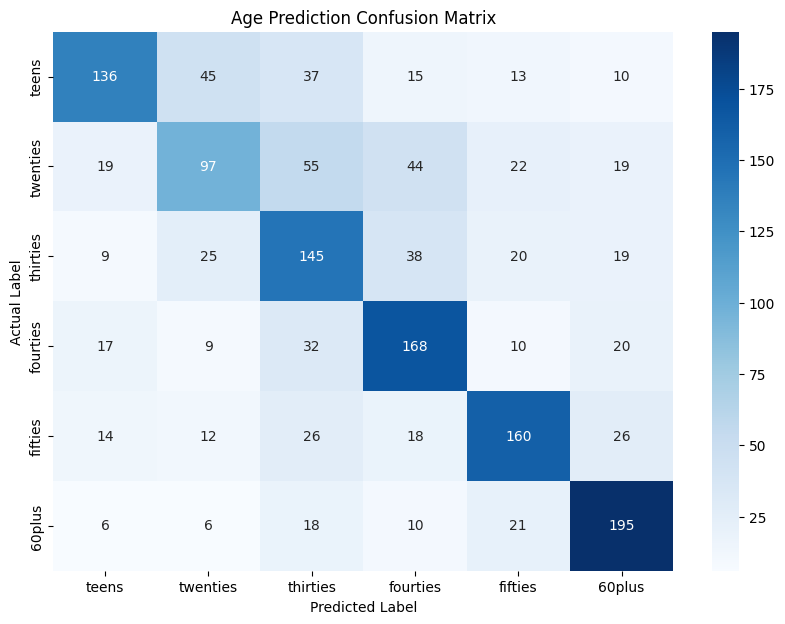

In [ ]:
AGE_MAP = {
    'teens': 0,
    'twenties': 1,
    'thirties': 2,
    'fourties': 3,
    'fifties': 4,
    '60plus': 5
}
GENDER_MAP = {'female': 0, 'male': 1}

NUM_AGE_CLASSES = 6
NUM_GENDER_CLASSES = 2

BATCH_SIZE = 32
MODEL_PATH = "/content/drive/MyDrive/voice_project/best_voice_model.pth"
STATS_PATH = "/content/drive/MyDrive/voice_project/scaling_stats"
FEATURES_PATH = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
TEST_LIST_PATH = "/content/drive/MyDrive/voice_project/test_list.csv"

# Detect Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Classes ---

class VoiceDataset(Dataset):
    def __init__(self, csv_file, features_dir, mean, std):
        self.data_list = pd.read_csv(csv_file)
        self.features_dir = features_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        row = self.data_list.iloc[idx]
        npy_filename = row['path'].replace(".mp3", ".npy")
        file_path = os.path.join(self.features_dir, npy_filename)

        try:
            spectrogram = np.load(file_path)
            norm_spectrogram = (spectrogram - self.mean) / self.std
            spec_tensor = torch.tensor(norm_spectrogram, dtype=torch.float32).unsqueeze(0)

            # Map labels
            age_label = torch.tensor(AGE_MAP[row['age']], dtype=torch.long)
            gender_label = torch.tensor(GENDER_MAP[row['gender']], dtype=torch.long)

            return spec_tensor, age_label, gender_label
        except:
            return torch.zeros((1, 128, 216)), torch.tensor(0), torch.tensor(0)

class VoiceCNN(nn.Module):
    def __init__(self, num_age_classes, num_gender_classes):
        super(VoiceCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1); self.bn1 = nn.BatchNorm2d(16); self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1); self.bn2 = nn.BatchNorm2d(32); self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1); self.bn3 = nn.BatchNorm2d(64); self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc_shared = nn.Linear(64 * 16 * 27, 128)
        self.fc_bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

        self.age_head = nn.Linear(128, num_age_classes)
        self.gender_head = nn.Linear(128, num_gender_classes)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(torch.nn.functional.relu(self.fc_bn(self.fc_shared(x))))
        return self.age_head(x), self.gender_head(x)

# 3. Load Data & Model ---

# Load Stats
GLOBAL_MEAN = np.load(os.path.join(STATS_PATH, "global_mean.npy"))
GLOBAL_STD = np.load(os.path.join(STATS_PATH, "global_std.npy"))

print("Creating test dataset and loader...")
test_dataset = VoiceDataset(TEST_LIST_PATH, FEATURES_PATH, GLOBAL_MEAN, GLOBAL_STD)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Loading best model from: {MODEL_PATH}")
model = VoiceCNN(num_age_classes=NUM_AGE_CLASSES, num_gender_classes=NUM_GENDER_CLASSES)


model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

model.to(device)
model.eval()

# 4. Run Test
all_age_preds = []
all_age_true = []
all_gender_preds = []
all_gender_true = []

with torch.no_grad():
    for specs, ages, genders in tqdm(test_loader, desc="Running Final Test"):
        specs = specs.to(device)
        ages = ages.to(device)
        genders = genders.to(device)

        age_preds, gender_preds = model(specs)

        _, predicted_age = torch.max(age_preds, 1)
        _, predicted_gender = torch.max(gender_preds, 1)

        all_age_preds.extend(predicted_age.cpu().numpy())
        all_age_true.extend(ages.cpu().numpy())
        all_gender_preds.extend(predicted_gender.cpu().numpy())
        all_gender_true.extend(genders.cpu().numpy())

# 5. Metrics
age_accuracy = 100 * (np.array(all_age_preds) == np.array(all_age_true)).mean()
gender_accuracy = 100 * (np.array(all_gender_preds) == np.array(all_gender_true)).mean()

print(f"\nOverall Gender Accuracy: {gender_accuracy:.2f}%")
print(f"Overall Age Accuracy:    {age_accuracy:.2f}%")

print("\n--- Age Classification Report ---")
age_labels = list(AGE_MAP.keys())
print(classification_report(all_age_true, all_age_preds, target_names=age_labels))

print("\n--- Age Confusion Matrix ---")
cm = confusion_matrix(all_age_true, all_age_preds)
cm_df = pd.DataFrame(cm, index=age_labels, columns=age_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Age Prediction Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()